In [1]:
import pandas as pd
import numpy as np

import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

Populating the interactive namespace from numpy and matplotlib


In [219]:
import cv2
image = cv2.imread('a3_45.png')
image.shape

(750, 7522, 3)

In [96]:
[0, 0, 0] in image

True

In [108]:
[255, 255, 255] in image

True

In [102]:
image[0][0]   # top-left (first) pixel is white
# [255, 255, 255] = white
# [0, 0, 0] = black
# [255, 0, 0] = blue
# [0, 128, 0] = green/olive

array([255, 255, 255], dtype=uint8)

In [103]:
image[749][7521]   # bottom-rigth (last) pixel is also white

array([255, 255, 255], dtype=uint8)

In [ ]:
# x = np.arange(37, 7487, 1)   #  x range 7450
# y = np.arange(47, 709, 1)   #  y range 662

Time taken: 36.6 seconds


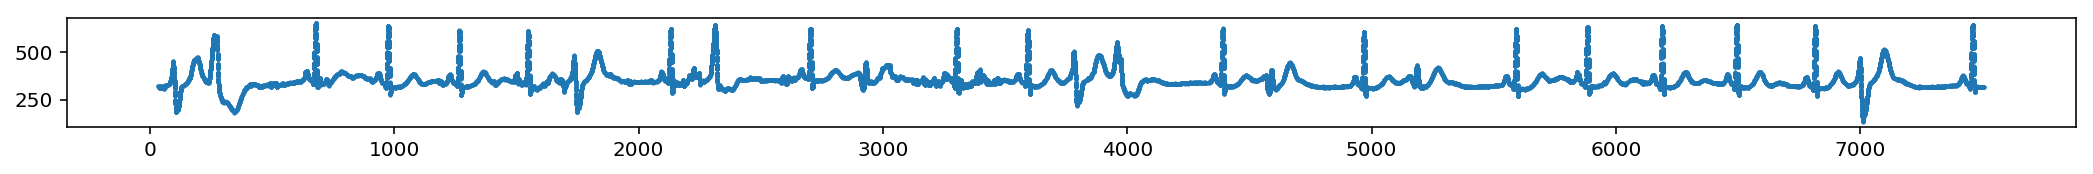

In [248]:
# to extract black pixel from entire image 7522 x 750 pixel
time1 = time.time() 
x_list, y_list = [], []

for y in np.arange(0, 750, 1):
    for x in np.arange(0, 7522, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # black
            x_list.append(x)
            y_list.append(750-y)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))

plt.figure(figsize = [18,5])   # [width, height]
plt.scatter(x_list, y_list, marker='.', s=5)

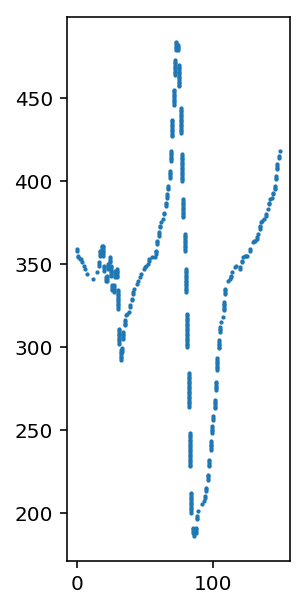

In [257]:
# to locate position of "V" (green/olive color)

position_list = []
y=45
x=0
while x<7522:
    if np.all(image[y][x] == (0, 128, 0)):
        position_list.append(x)
        x += 25
    x += 1

# to extract data points for V-beat
x_list, y_list = [], []

# to iterate for position[i]
i = 2
begin = position_list[i]-65
end = position_list[i]+85
for y in np.arange(0, 750, 1):
    for x in np.arange(begin, end, 1):
        if np.all(image[y][x] == (0, 0, 0)):
            x_list.append(x-begin)
            y_list.append(750-y)

plt.figure(figsize = [2,5])   # [width, height]
plt.scatter(x_list, y_list, marker='.', s=5)

In [254]:
X = []
X.append([x_list, y_list])
y.append("V")

1

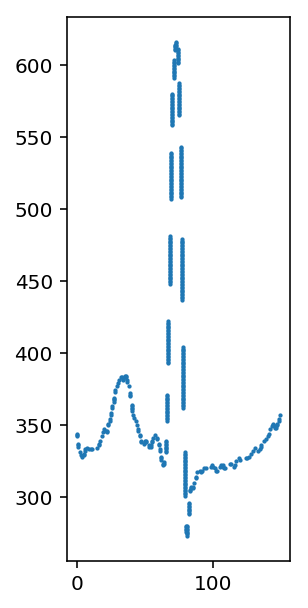

In [252]:
# to locate position of "N" (blue color)

position_list = []
y=45
x=0
while x<7522:
    if np.all(image[y][x] == (255, 0, 0)):
        position_list.append(x)
        x += 25
    x += 1

# to extract data points for N graph
x_list, y_list = [], []

# to iterate for position[i]
i = 2
begin = position_list[i]-65
end = position_list[i]+85
for y in np.arange(0, 750, 1):
    for x in np.arange(begin, end, 1):
        if np.all(image[y][x] == (0, 0, 0)):
            x_list.append(x-begin)
            y_list.append(750-y)

plt.figure(figsize = [2,5])   # [width, height]
plt.scatter(x_list, y_list, marker='.', s=5)
plt.show()

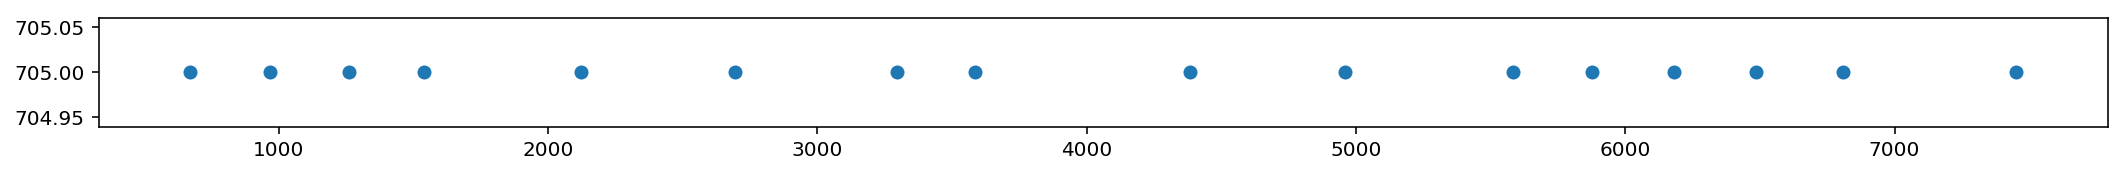

In [222]:
# to locate position of "N" (blue color)

x_list, y_list = [], []
y=45
x=0
while x<7522:
    if np.all(image[y][x] == (255, 0, 0)):
        x_list.append(x)
        y_list.append(750-y)
        x += 25
    x += 1

plt.figure(figsize = [18,1])   # [width, height]
plt.scatter(x_list, y_list)

In [223]:
x_list

[670,
 968,
 1259,
 1540,
 2123,
 2695,
 3294,
 3585,
 4382,
 4960,
 5583,
 5875,
 6181,
 6486,
 6807,
 7452]

In [224]:
len(x_list)

16